**классификатор текстов LSTM на Keras+TensorFlow**

Евгений Борисов <borisov.e@solarl.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm

In [2]:
tqdm.pandas()

/usr/lib/python3.9/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [4]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [5]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [6]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [7]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [8]:
data.sample(10)

,id,ttext,ttype
84664,420629943966785536,"Добре поколядували ,але не довго(\nЗато в светия дізналась багато чого нового азазаз",-1
17411,409370547244765184,"ой, Ник!)) ) сами подумайте. что такое сша? страна -бывших преступников и проституток,",1
62257,416813321971433472,"@perduemonocle ааа, ты про марево. Там да, приходится падать ((( Но игра не столь уж сложная, ребенок справится",-1
111640,411203392707362816,"@VikaKomolova ааааа,я в ожидании))постараюсь не удивляться))",1
7507,409097011901005824,Добраться бы до студии еще... пока не замело совсем... пока парни еще ждут... видосик надо готовить),1
12581,410776422811443200,"Весь деня спать хочу, настроение ужасное((",-1
64777,417016594989326336,"грустно :(""@Fontanka_spb: http://t.co/MmE3qzGefj запретили http://t.co/gtKcyzaPbv""",-1
46916,410002463593205760,"@NikaIgnatova да забей на все, зайди в вк и наслаждайся музыкой)",1
39988,413911345378365440,Ну и не пиши мне(\n\nЯ теперь не буду никому писать первой,-1
10711,409290828813574144,"ну наконец то дома.Но сейчас поедем кататься с мамой,просто не могу ей отказать:)",1


## токенизация и очистка

In [9]:
# from pymorphy2 import MorphAnalyzer

In [10]:
# # собираем словарь из текстов
# def get_vocabulary(ds):
#     vcb = [ set(s) for s in ds.tolist() ]
#     return sorted(set.union(*vcb))

In [11]:
# # лемматизация и очистка с помощью пакета морфологического анализа

# morph = MorphAnalyzer()

# # применяет список замен pat к строке s
# def replace_patterns(s,pat):
#     if len(pat)<1: return s
#     return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# # нормализация текста
# def string_normalizer(s):
#     pat = [
#        [r'ё','е'] # замена ё для унификации
#        ,[r'</?[a-z]+>',' '] # удаляем xml
#        ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
#        ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
#        ,[r'\w+- ',' ']
#        ,[r' +',' '] # удаляем повторы пробелов
#     ]
#     return replace_patterns(s.lower(),pat).strip()

# # NOUN (существительное), VERB (глагол), ADJF (прилагательное)
# def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
#     if not morph.word_is_known(w): return ''
#     p = morph.parse(w)[0] 
#     return p.normal_form if (p.tag.POS in pos_types) else ''


# def tokenize_normalize(s):
#     return [ word_normalizer(w) for w in s.split(' ') if len(w)>1 ]

In [12]:
# data['ctext'] = data['ttext'].progress_apply(string_normalizer).progress_apply( tokenize_normalize )

In [13]:
# vcb0 =  get_vocabulary( data['ctext'] )
# print('словарь %i слов'%(len(vcb0)))
# # pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

In [14]:
# data['ctext'] = data['ctext'].apply( ' '.join  )

In [15]:
# data.sample(10)

## очистка данных

In [16]:
data['ttext_clean'] = data['ttext'].progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )

100%|██████████| 226833/226833 [00:00<00:00, 276841.68it/s]


In [17]:
data['ttext_clean'] = data['ttext_clean'].progress_apply(
    lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t  ]
  )

100%|██████████| 226833/226833 [00:01<00:00, 114914.37it/s]


In [18]:
data['ttext_clean'] = data['ttext_clean'].progress_apply(
    lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ]
  )

100%|██████████| 226833/226833 [00:01<00:00, 119344.59it/s]


In [19]:
data['ttext_clean'] = data['ttext_clean'].progress_apply(
    lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ]
  )

100%|██████████| 226833/226833 [00:01<00:00, 122108.44it/s]


In [20]:
data['ttext_clean'] = data['ttext_clean'].progress_apply(
    lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ]
  )

100%|██████████| 226833/226833 [00:01<00:00, 117745.36it/s]


In [21]:
data['ttext_clean'] = data['ttext_clean'].progress_apply(
    lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ]
  )

100%|██████████| 226833/226833 [00:01<00:00, 123654.23it/s]


In [22]:
data['ttext_clean'] = data['ttext_clean'].progress_apply(
    lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ]
  )

100%|██████████| 226833/226833 [00:01<00:00, 120430.87it/s]


In [23]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [24]:
data['ttext_clean'] = data['ttext_clean'].str.lower()
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda s: re.sub( r'\W', ' ', s))
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda s: re.sub( r'_', ' ', s))
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s)) 


100%|██████████| 226833/226833 [00:00<00:00, 337222.16it/s]


In [25]:
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )

100%|██████████| 226833/226833 [00:00<00:00, 289389.97it/s]


In [26]:
# замена буквенно-цифровых кодов
data['ttext_clean'] = data['ttext_clean'].progress_apply(
    lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ]
)

100%|██████████| 226833/226833 [00:02<00:00, 107798.18it/s]


In [27]:
data.sample(3)

,id,ttext,ttype,ttext_clean
93060,410866873883193344,Самые хорошие друзья - это мои!!! ))) http://t.co/z8ybGFlEU6,1,"[самые, хорошие, друзья, это, мои, happysmile, url]"
98356,422997209148166144,"@AlexaPgk вырывай его сразу лучше, потом будет ооочень больно и плохо :(",-1,"[alexapgk, вырывай, его, сразу, лучше, потом, будет, ооочень, больно, и, плохо, sadsmile]"
33885,413284428417622017,это была лучшая и одновременно самая худшая ночь в моей жизни...(((,-1,"[это, была, лучшая, и, одновременно, самая, худшая, ночь, в, моей, жизни, sadsmile]"


---

In [28]:
# from nltk import download as nltk_download
# nltk_download('stopwords')
# from Stemmer import Stemmer

# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords as nltk_stopwords
# stopwords = set(nltk_stopwords.words('russian') )

In [29]:
# with gzip.open('../data/text/stop-nltk.txt.gz','rt',encoding='utf-8') as f: 
#     stopwords = set([ w.strip() for w in  f.read().split() if w.strip() ] )

# ppr(stopwords)

In [30]:
# удаление лишних слов
# data['ttext_clean'] = data['ttext_clean'].apply(lambda t:[w for w in t if w not in stopwords])

In [31]:
# %xdel stopwords

In [32]:
# %%time 

# from Stemmer import Stemmer
# # pacman -S python-pystemmer
# # pip install pystemmer

# # стемминг, выделение основы слова
# data['ttext_clean'] = data['ttext_clean'].apply( lambda t:Stemmer('russian').stemWords(t) )

In [33]:
# удаление коротких слов
data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

100%|██████████| 226833/226833 [00:00<00:00, 351550.56it/s]


---

In [34]:
# data[ data['ttext_clean'].str.len()<1 ][['ttext_clean']]

In [35]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 831


In [36]:
data.sample(3)

,id,ttext,ttype,ttext_clean
35531,409776438058172416,RT @_Milosvetova: @katherin_yes поздравляю с твоим днем красотка!)),1,"[milosvetova, katherin, yes, поздравляю, твоим, днем, красотка, happysmile]"
25711,409565748055781376,"RT @randlape: Вах, столько поздравлений, не ожидал. Спасибо всем! :) Пятница, суббота у меня выходные - ждите много интересных фактов!",1,"[randlape, вах, столько, поздравлений, ожидал, спасибо, всем, happysmile, пятница, суббота, меня, выходные, ждите, много, интересных, фактов]"
16669,409363112769253376,Мне определённо нравятся обнимашки с @LenaVasilevaD :*,1,"[мне, определённо, нравятся, обнимашки, lenavasilevad, kisssmile]"


## строим датасет

In [37]:
vocab = ['<PAD>'] + sorted(set([ w for t in data['ttext_clean'] for w in t if w ]))
vocab = { w:n for n,w in enumerate(vocab) }
ppr(vocab)

записей: 239 518


In [38]:
n_max = data['ttext_clean'].str.len().max()
n_max

32

In [39]:
pad = ['<PAD>']*n_max

In [40]:
data[['ttext_clean']]

,ttext_clean
0,"[все, таки, немного, похож, него, мой, мальчик, все, равно, лучше, happysmile]"
1,"[katiacheh, идиотка, испугалась, тебя]"
2,"[кто, углу, сидит, погибает, голода, ещё, digit, порции, взяли, хотя, уже, так, жрать, хотим, happysmile, url]"
3,"[irina, dyshkant, вот, что, значит, страшилка, happysmile, блин, посмотрев, все, части, тебя, создастся, ощущение, что, авторы, курили, что, happysmile]"
4,"[любишь, или, нет, знаю, кто, бля, happysmile, url]"
...,...
226826,"[каждый, хочет, что, исправлять, sadsmile, url]"
226827,"[скучаю, так, только, taaannyaaa, вправляет, мозги, все, равно, скучаю]"
226828,"[вот, школу, говно, это, идти, уже, надо]"
226829,"[them, lisaberoud, тауриэль, грусти, sadsmile, обнял]"


In [41]:
data['ttext_clean'] = data['ttext_clean'].progress_apply(
    lambda t: pad[len(t):] + list(reversed(t)) 
  )

100%|██████████| 226831/226831 [00:00<00:00, 349981.78it/s]


In [42]:
data[['ttext_clean']]

,ttext_clean
0,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, happysmile, лучше, равно, все, мальчик, мой, нег..."
1,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>,..."
2,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, url, happysmile, хотим, жрать, так, уже, хотя, взяли, порции, digit, ещё, голода, п..."
3,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, happysmile, что, курили, авторы, что, ощущение, создастся, тебя, части, все, посмотрев, блин, happysmile..."
4,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, url, happysmile, бля, кто, ..."
...,...
226826,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, url, sadsmile..."
226827,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, скучаю, равно, все, мозги, вправля..."
226828,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, надо, уже, идти, это..."
226829,"[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, обнял, sadsmi..."


In [43]:
data['ttext_code'] = data['ttext_clean'].progress_apply(lambda t: [ vocab[w] for w in t ] )

100%|██████████| 226831/226831 [00:01<00:00, 198424.36it/s]


In [44]:
data['ttext_code'].values

array([list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21932, 134722, 187697, 89214, 136511, 141026, 148276, 178077, 149307, 211286, 89214]),
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 212621, 119895, 117135, 27794]),
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 61231, 21932, 228419, 108716, 211256, 219378, 228440, 85334, 176332, 13805, 107151, 95465, 170073, 199030, 218583, 130035]),
       ...,
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 144360, 219378, 117173, 237045, 95113, 234141, 88670]),
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 154299, 51505, 97224, 212063, 33806, 58779]),
       list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51505, 150488, 133643, 236973, 187415, 89883, 138734, 232375, 181864, 188709, 187641, 138734, 83981, 211362])],
      dtype=object)

In [45]:
x = np.stack( data['ttext_code'].values).astype(np.int)
x.shape

(226831, 32)

In [46]:
n_classes=2
target = data['ttype'].values
target = (target+1)//2
y = np.eye(n_classes)[target]

y.shape

(226831, 2)

In [47]:
max_word = x.max()
seq_len = x.shape[1]
x.shape , y.shape, max_word, seq_len

((226831, 32), (226831, 2), 239517, 32)

In [48]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=.4 )
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((136098, 32), (136098, 2), (90733, 32), (90733, 2))

In [49]:
y_train.sum(axis=0),y_test.sum(axis=0),

(array([67052., 69046.]), array([44870., 45863.]))

## строим нейросеть 

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [51]:
embedding_size = 64

model = Sequential()
model.add(Embedding( input_dim = max_word+1, output_dim = embedding_size, input_length = seq_len,))
model.add(LSTM(32))
model.add(Dense(n_classes, activation='softmax'))

In [52]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [53]:
%%time

hist = model.fit(x_train,y_train, batch_size=1024, epochs=9, validation_split=.3)

Epoch 1/9
94/94 [==============================] - 8s 81ms/step - loss: 0.4631 - accuracy: 0.7792 - val_loss: 0.2471 - val_accuracy: 0.8923
Epoch 2/9
94/94 [==============================] - 7s 77ms/step - loss: 0.1628 - accuracy: 0.9342 - val_loss: 0.2268 - val_accuracy: 0.8955
Epoch 3/9
94/94 [==============================] - 7s 77ms/step - loss: 0.0812 - accuracy: 0.9706 - val_loss: 0.2628 - val_accuracy: 0.8906
Epoch 4/9
94/94 [==============================] - 7s 77ms/step - loss: 0.0466 - accuracy: 0.9842 - val_loss: 0.3144 - val_accuracy: 0.8834
Epoch 5/9
94/94 [==============================] - 7s 77ms/step - loss: 0.0319 - accuracy: 0.9902 - val_loss: 0.3816 - val_accuracy: 0.8824
Epoch 6/9
94/94 [==============================] - 7s 78ms/step - loss: 0.0215 - accuracy: 0.9936 - val_loss: 0.3853 - val_accuracy: 0.8844
Epoch 7/9
94/94 [==============================] - 7s 78ms/step - loss: 0.0150 - accuracy: 0.9957 - val_loss: 0.4026 - val_accuracy: 0.8846
Epoch 8/9
94/94 [===

In [54]:
model.evaluate(x_test ,y_test )

2836/2836 [==============================] - 3s 1ms/step - loss: 0.5439 - accuracy: 0.8818


[0.5439070463180542, 0.8818401098251343]

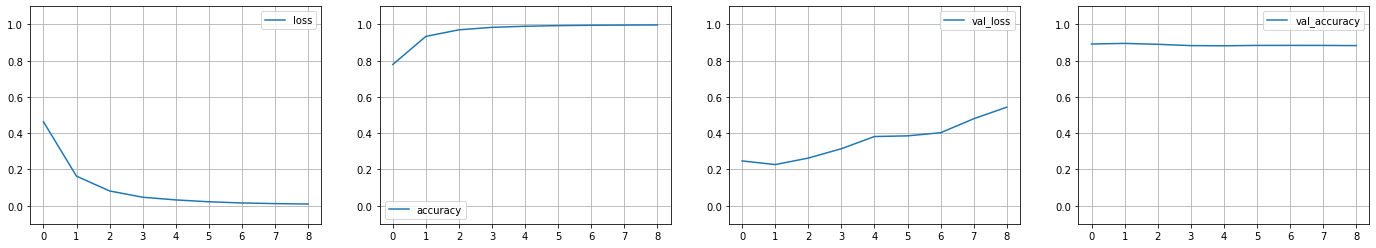

In [58]:
from matplotlib import pyplot as plt

k = hist.history.keys()

w,h = 6,4

fig,ax = plt.subplots(1,len(k),figsize=(w*len(k),h))
for i,n in enumerate(k):
    ax[i].plot(hist.history[n],label=n)
    ax[i].grid(True)
    ax[i].legend()
    ax[i].set_ylim([-.1,1.1])